In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab
%matplotlib inline
import seaborn as sns
import pandas as pd
global tf
import tensorflow as tf
from IPython.display import display, HTML
import python_utils as utils
from natsort import natsorted
import glob
import os
import time
import itertools
from itertools import cycle
from collections import defaultdict

import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Dropout, Activation, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

from scipy import stats
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import sklearn
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
name = 'VAE'
path_to_TB = os.getcwd()+'/AUC_ROC/TB_data/'+name
call_tensorboard = keras.callbacks.TensorBoard(log_dir=path_to_TB+'logs/{}'.format(name))
filepath = path_to_TB + "/checkpoint/" + name + "-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
call_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [call_tensorboard, call_checkpoint]

In [6]:
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
plt.show()
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def draw_heat_map(report):
    plot_classification_report(report)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
       
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])

In [7]:
sns.set()

In [8]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [9]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [10]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [11]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [12]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

In [13]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 35us/step - loss: 200.6855 - val_loss: 173.3778
Epoch 2/50
60000/60000 [==============================] - 2s 30us/step - loss: 170.0273 - val_loss: 168.3462
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 166.3972 - val_loss: 165.4010
Epoch 4/50
60000/60000 [==============================] - 2s 31us/step - loss: 164.1403 - val_loss: 163.7661
Epoch 5/50
60000/60000 [==============================] - 3s 46us/step - loss: 162.3760 - val_loss: 161.9289
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 160.7861 - val_loss: 160.6763
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 159.5293 - val_loss: 159.2592
Epoch 8/50
60000/60000 [==============================] - 3s 50us/step - loss: 158.5575 - val_loss: 158.5619
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss:

In [16]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_train, batch_size=batch_size)

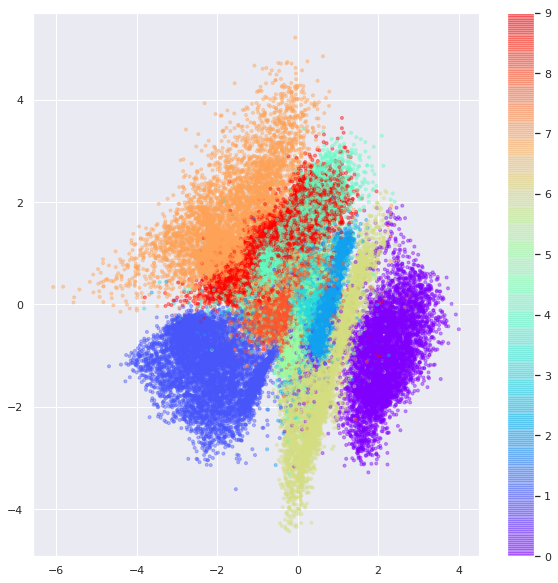

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_train,
            alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

In [11]:
np.save('VAE_results.npy', z_test)

NameError: name 'z_test' is not defined

In [9]:
x_test_encoded = np.load('VAE_results.npy')

In [26]:
x_test_encoded.shape

(60000, 2)

In [10]:
train, validate, test = np.split(x_test_encoded, [int(.9*len(x_test_encoded)), int(.95*len(x_test_encoded))])

In [11]:
train, validate, test = train.reshape(54000, 2) / 255 , validate.reshape(3000, 2) / 255, test.reshape(3000,2) / 255

In [12]:
train_y, validate_y, test_y = np.split(y_train, [int(.9*len(y_train)), int(.95*len(y_train))])

In [13]:
num_classes=10

In [14]:
train_y =  keras.utils.to_categorical(train_y, num_classes)
validate_y = keras.utils.to_categorical(validate_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [15]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
__________

In [16]:
def optimize_and_fit(model, lr, epochs):
        Adam = optimizers.Adam(lr=lr)
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x=train, y=train_y, batch_size =64, 
                    validation_data = (validate, validate_y),
                    callbacks = callbacks_list,
                    epochs = epochs,
                    shuffle = True,
                    verbose = 1
                    )

In [24]:
optimize_and_fit(model, 1e-4, 1000)

Train on 54000 samples, validate on 3000 samples
Epoch 1/1000
54000/54000 [==============================] - 2s 45us/step - loss: 0.8176 - acc: 0.7005 - val_loss: 0.7657 - val_acc: 0.7190

Epoch 00001: val_acc improved from -inf to 0.71900, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/VAE/checkpoint/VAE-improvement-01-0.72.hdf5
Epoch 2/1000
54000/54000 [==============================] - 2s 40us/step - loss: 0.8074 - acc: 0.7056 - val_loss: 0.7045 - val_acc: 0.7410

Epoch 00002: val_acc improved from 0.71900 to 0.74100, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/VAE/checkpoint/VAE-improvement-02-0.74.hdf5
Epoch 3/1000
54000/54000 [==============================] - 2s 41us/step - loss: 0.7986 - acc: 0.7075 - val_loss: 0.7213 - val_acc: 0.7420

Epoch 00003: val_acc improved from 0.74100 to 0.74200, saving model to /media/hamza/648AE5748AE542E2/data/dimensionality_reduction/AUC_ROC/TB_data/VAE/c


Epoch 00038: val_acc did not improve from 0.75400
Epoch 39/1000
 6656/54000 [==>...........................] - ETA: 1s - loss: 0.7216 - acc: 0.7416

KeyboardInterrupt: 

In [27]:
predictions = model.predict(test, batch_size=128, verbose=1)

3000/3000 [==============================] - 0s 33us/step


Confusion matrix, without normalization
[[267   0   3   6   1   5  14   0   1   0]
 [  0 314   0   1   0   2   3   0   5   0]
 [  1   0 273  27   0   0   2   0   4   2]
 [  0   0   4 280   1  17   0   0  11   1]
 [  0   3   3   2 216   3   0   1   8  54]
 [  0   0   4 114   3  99   3   0  37   2]
 [ 13   0   1   2   0   3 269   0   0   0]
 [  0   0   0   1  12   0   0 290   1  28]
 [  1   2   5  46   5  20   0   1 217   0]
 [  0   0   0   5  89   0   0  25   8 159]]


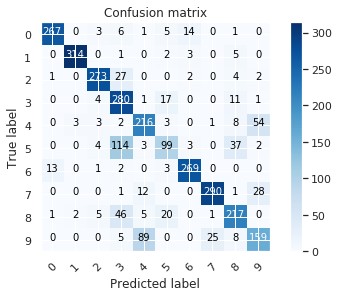

In [36]:
prediction_label, true_label = predictions_to_label_array(predictions), predictions_to_label_array(test_y)
cm = confusion_matrix(true_label, prediction_label)
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

In [37]:
report = classification_report(true_label, prediction_label, target_names=cm_plot_labels)

In [38]:
report_df = pd.DataFrame(report2dict(report)).T
report_df

,f1-score,precision,recall,support
0,0.92,0.95,0.90,297.0
1,0.98,0.98,0.97,325.0
2,0.91,0.93,0.88,309.0
3,0.70,0.58,0.89,314.0
4,0.70,0.66,0.74,290.0
5,0.48,0.66,0.38,262.0
6,0.93,0.92,0.93,288.0
7,0.89,0.91,0.87,332.0
8,0.74,0.74,0.73,297.0
9,0.60,0.65,0.56,286.0


[0.95, 0.9, 0.92]
[0.98, 0.97, 0.98]
[0.93, 0.88, 0.91]
[0.58, 0.89, 0.7]
[0.66, 0.74, 0.7]
[0.66, 0.38, 0.48]
[0.92, 0.93, 0.93]
[0.91, 0.87, 0.89]
[0.74, 0.73, 0.74]
[0.65, 0.56, 0.6]
plotMat: [[0.95, 0.9, 0.92], [0.98, 0.97, 0.98], [0.93, 0.88, 0.91], [0.58, 0.89, 0.7], [0.66, 0.74, 0.7], [0.66, 0.38, 0.48], [0.92, 0.93, 0.93], [0.91, 0.87, 0.89], [0.74, 0.73, 0.74], [0.65, 0.56, 0.6]]
support: [297, 325, 309, 314, 290, 262, 288, 332, 297, 286]


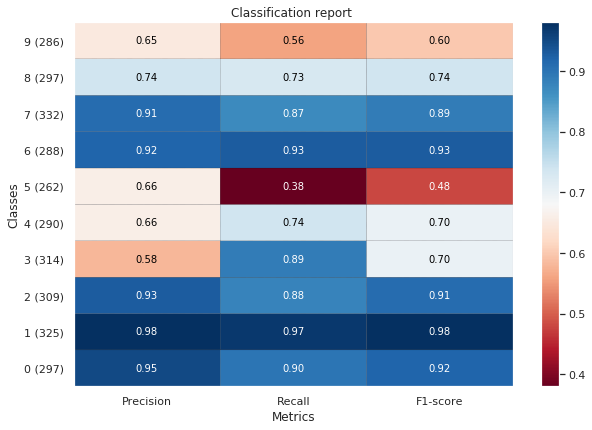

In [39]:
draw_heat_map(report)

In [42]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

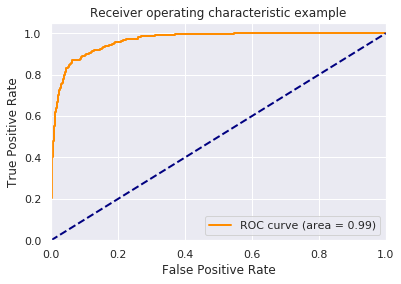

In [43]:
plt.figure()
lw = 2
plt.plot(fpr[8], tpr[8], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

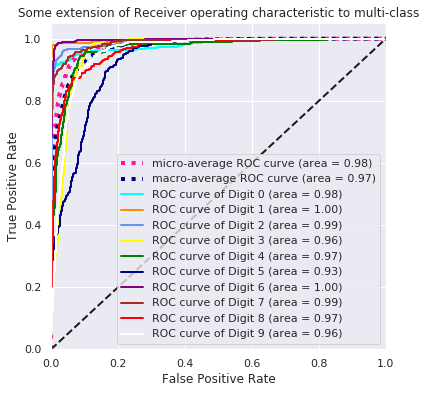

In [44]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'green', 'navy', 'purple', 'brown', 'red', 'white'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of Digit {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_train,
#            alpha=.4, s=3**2, cmap='rainbow')
#plt.colorbar()
#plt.show()    
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [62]:
print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# #############################################################################
# Generate sample data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = x_train.copy()
#tsne_results = np.load('tsne_results.npy')
#X, validate, test = np.split(tsne_results, [int(.9*len(tsne_results)), int(.95*len(tsne_results))])
#X = X.reshape(54000, 2) / 255
#train_y, validate_y, test_y = np.split(y_train, [int(.9*len(y_train)), int(.95*len(y_train))])
#
#X = X[0:5000]
labels_true = train_y[0:5000]

Automatically created module for IPython interactive environment


In [63]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X[0:5000])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [57]:
cluster_centers_indices = np.arange(10)

In [58]:
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

Estimated number of clusters: 10
Homogeneity: 1.000
Completeness: 0.270
V-measure: 0.425
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


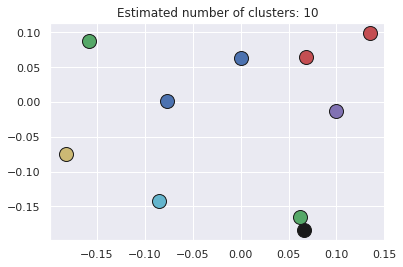

In [60]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

# #############################################################################
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()